### Download Prem Data

Using the [football-data.co.uk](https://www.football-data.co.uk/englandm.php) and ~~pandas~~ polars to load the Premier League results for the 2021/22, 2022,2023 and 2023/2024 seasons.

In [ ]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import posteriors
from datetime import datetime # will try to avoid this import later


def download_data(start=21, end=24, important_cols=["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG"]):
    urls = [
        f"https://www.football-data.co.uk/mmz4281/{y}{y+1}/E0.csv"
        for y in range(start, end)
    ]


    origin_date = datetime.strptime(f"20{start}-08-01", "%Y-%m-%d").date() 
    data = pl.concat(pl.read_csv(url) for url in urls)

    data = data.drop_nulls(subset=important_cols) # changed this from the original as it tended to drop too many rows unecessarily

    data = data.with_columns(
        pl.col("Date").str.to_date().alias("Timestamp")
    )

    data = data.with_columns(
        (pl.col("Timestamp") - origin_date)
        .dt.total_days().alias("TimestampDays") #days from the start of the season
    )
    
    players_arr = pl.concat([data["HomeTeam"], data["AwayTeam"]]).unique().to_numpy()
    players_arr.sort()
    players_name_to_id_dict = {a: i for i, a in enumerate(players_arr)}
    players_id_to_name_dict = {i: a for i, a in enumerate(players_arr)}

    data = data.with_columns(
        pl.col("HomeTeam", "AwayTeam")
        .replace_strict(players_name_to_id_dict).name.suffix("ID")
    )
    
    match_times = torch.tensor(data["TimestampDays"].to_numpy(), dtype=torch.float64)
    match_player_indices = torch.tensor(data["HomeTeamID", "AwayTeamID"].to_numpy())

    home_goals = torch.tensor(data["FTHG"].to_numpy())
    away_goals = torch.tensor(data["FTAG"].to_numpy())
    
    match_results = torch.where(
        home_goals > away_goals, 1, torch.where(home_goals < away_goals, 2, 0)
    )

    dataset = torch.utils.data.StackDataset(
        match_times=match_times,
        match_player_indices=match_player_indices,
        match_results=match_results,
    )

    return (
        dataset,
        players_id_to_name_dict,
        players_name_to_id_dict,
    )

In [22]:
(
    dataset,
    players_id_to_name_dict,
    players_name_to_id_dict,
) = download_data()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

This likelihood function $p(y | x^{h}, x^{a})$ maps the skills of the teams to the probability of a draw $(y = d)$, home-win $(y = h)$ or away-win $(y = a)$. Following Duffield et al


In [23]:
epsilon = 1.0


def log_likelihood(params, batch):
    player_indices = batch["match_player_indices"]
    match_results = batch["match_results"]

    player_skills = params[player_indices]

    home_win_prob = torch.sigmoid(
        player_skills[:, 0] - player_skills[:, 1] - epsilon
    ) # y = h
    away_win_prob = 1 - torch.sigmoid(
        player_skills[:, 0] - player_skills[:, 1] + epsilon
    ) # y = a
    draw_prob = 1 - home_win_prob - away_win_prob # y = d
    result_probs = torch.vstack([draw_prob, home_win_prob, away_win_prob]).T
    log_liks = torch.log(result_probs[torch.arange(len(match_results)), match_results])
    return log_liks, result_probs

Run an [Extended Kalman filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter) to infer the skills of the teams sequentially over the matches.

In [24]:
transition_sd_scale = 0.1
num_teams = len(players_id_to_name_dict)

init_means = torch.zeros((num_teams,))
init_sds = torch.ones((num_teams,))

state = posteriors.ekf.diag_fisher.init(init_means, init_sds)
all_means = init_means.unsqueeze(0)
all_sds = init_sds.unsqueeze(0)
previous_time = 0.0
for match in dataloader:
    match_time = match["match_times"]
    state, aux = posteriors.ekf.diag_fisher.update(
        state,
        match,
        log_likelihood,
        lr=1.0,
        per_sample=True,
        transition_sd=torch.sqrt(transition_sd_scale**2 * (match_time - previous_time)),
    )
    all_means = torch.vstack([all_means, state.params.unsqueeze(0)])
    all_sds = torch.vstack([all_sds, state.sd_diag.unsqueeze(0)])
    previous_time = match_time

380


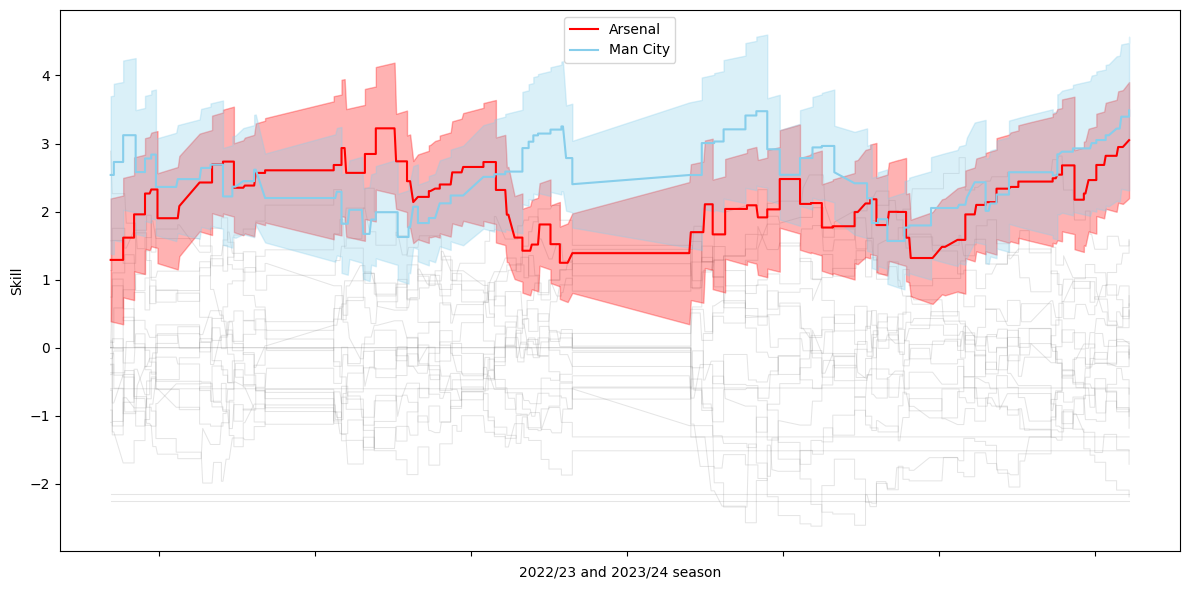

In [ ]:
last_season_start = (len(all_means) - 1) // 3

times = dataset.datasets["match_times"][last_season_start:]
means = all_means[last_season_start + 1 :]
sds = all_sds[last_season_start + 1 :]

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(num_teams):
    team_name = players_id_to_name_dict[i]
    if team_name in ("Arsenal", "Man City"):
        c = "skyblue" if team_name == "Man City" else "red"
        ax.plot(times, means[:, i], c=c, zorder=2, label=team_name)
        ax.fill_between(
            times,
            means[:, i] - sds[:, i],
            means[:, i] + sds[:, i],
            color=c,
            alpha=0.3,
            zorder=1,
        )
    else:
        ax.plot(times, means[:, i], c="grey", alpha=0.2, zorder=0, linewidth=0.75)

ax.set_xticklabels([])
ax.set_xlabel("2022/23 and 2023/24 season")
ax.set_ylabel("Skill")
ax.legend()
fig.tight_layout()